Импорт нужных модулей.

In [3]:
from google.colab import drive
from tensorflow.keras.layers import *
from tensorflow.keras.metrics import *
from tensorflow.keras.models import Sequential, Model
import numpy as np
import pandas as pd
import os
import tensorflow.keras.backend as K
from sklearn.metrics import *
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.preprocessing import MinMaxScaler
import pickle
import seaborn as sns
from matplotlib import pyplot as plt 
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


Анализ датасета.
Для этого, в основном, будут использоваться инструменты pandas dataframe. А также библиотек sklearn и seaborn.

===========================================================

Dataset Analysis
Main tool is pandas dataframe, sklearn and seaborn as instrument for nice heatmap.

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#Загрузка датасета по частям с дальнейшей конкатенацией. 
df1=pd.read_csv("/content/drive/MyDrive/CICIDS2017/data_analysis/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv")#,nrows = 50000
df2=pd.read_csv("/content/drive/MyDrive/CICIDS2017/data_analysis/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv")
df3=pd.read_csv("/content/drive/MyDrive/CICIDS2017/data_analysis/Friday-WorkingHours-Morning.pcap_ISCX.csv")
df4=pd.read_csv("/content/drive/MyDrive/CICIDS2017/data_analysis/Monday-WorkingHours.pcap_ISCX.csv")
df5=pd.read_csv("/content/drive/MyDrive/CICIDS2017/data_analysis/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv")
df6=pd.read_csv("/content/drive/MyDrive/CICIDS2017/data_analysis/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv")
df7=pd.read_csv("/content/drive/MyDrive/CICIDS2017/data_analysis/Tuesday-WorkingHours.pcap_ISCX.csv")
df8=pd.read_csv("/content/drive/MyDrive/CICIDS2017/data_analysis/Wednesday-workingHours.pcap_ISCX.csv")

#Вывод уникальных признаков типов аттак или benign для каждого датасета. Ожидается DDoS, DoS Types и т.д.
print (df1[' Label'].unique())
print (df2[' Label'].unique())
print (df3[' Label'].unique())
print (df4[' Label'].unique())
print (df5[' Label'].unique())
print (df6[' Label'].unique())
print (df7[' Label'].unique())
print (df8[' Label'].unique(), "\n")

#Конкатенация и общая информация о наборе данных
df = pd.concat([df1,df2])
del df1,df2
df = pd.concat([df,df3])
del df3
df= pd.concat([df,df4])
del df4
df = pd.concat([df,df5])
del df5
df = pd.concat([df,df6])
del df6
df = pd.concat([df,df7])
del df7
df = pd.concat([df,df8])
del df8
data = df.copy() #Датафрейм копируем в дату для дальнейших операций
data.info()



['BENIGN' 'DDoS']
['BENIGN' 'PortScan']
['BENIGN' 'Bot']
['BENIGN']
['BENIGN' 'Infiltration']
['BENIGN' 'Web Attack � Brute Force' 'Web Attack � XSS'
 'Web Attack � Sql Injection']
['BENIGN' 'FTP-Patator' 'SSH-Patator']
['BENIGN' 'DoS slowloris' 'DoS Slowhttptest' 'DoS Hulk' 'DoS GoldenEye'
 'Heartbleed'] 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2830743 entries, 0 to 692702
Data columns (total 79 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0    Destination Port             int64  
 1    Flow Duration                int64  
 2    Total Fwd Packets            int64  
 3    Total Backward Packets       int64  
 4   Total Length of Fwd Packets   int64  
 5    Total Length of Bwd Packets  int64  
 6    Fwd Packet Length Max        int64  
 7    Fwd Packet Length Min        int64  
 8    Fwd Packet Length Mean       float64
 9    Fwd Packet Length Std        float64
 10  Bwd Packet Length Max         int64  
 11   Bwd Packet Len

<h4>Необязательный шаг.</h4>

Тепловая карта для сырого датасета. Благодаря ней можно понять основные недостатки сырого датасета и с ними работать в дальнейшем препроцессинге.

In [ ]:
#fig= plt.figure(figsize=(70,70))
#sns.heatmap(data.corr(), annot=True)

Необходимо отбросить пустые значения из изначального датасета.

In [4]:
#Подтягиваем из датасета колонки с NaN и создаем из них массив deleteCol. Получившийся массив "вычитаем" из дата.
deleteCol = []
for column in data.columns:
    if data[column].isnull().values.any():
        deleteCol.append(column)
for column in deleteCol:
    data.drop([column],axis=1,inplace=True)


Аналогично поступаем с элементами numpy.object

In [5]:
deleteCol = []
for column in data.columns:
    if column == ' Label':
        continue
    elif data[column].dtype==np.object:
        deleteCol.append(column)
for column in deleteCol:
    data.drop(column,axis=1,inplace=True)


Выявим уникальные значения метрики Flow Duration

In [6]:
data[' Flow Duration'].unique()

array([       3,      109,       52, ..., 11509095, 11512230,  1048635])

Привидем каждый столбец к единому числовому типу на основе максимального значения в выбранном столбце.

In [7]:
#int8   от отрицательного -128 до положительного 127
#int16  от отрицательного -32768 до положительных 32767
#int32  от отрицательного 2 147 483 648 до положительного 2 147 483 647

for column in data.columns:
    if data[column].dtype == np.int64:
        maxVal = data[column].max()
        if maxVal < 120:
            data[column] = data[column].astype(np.int8)
        elif maxVal < 32767:
            data[column] = data[column].astype(np.int16)
        else:
            data[column] = data[column].astype(np.int32)
            
    if data[column].dtype == np.float64:
        maxVal = data[column].max()
        minVal = data[data[column]>0][column]
        if maxVal < 120 and minVal>0.01 :
            data[column] = data[column].astype(np.float16)
        else:
            data[column] = data[column].astype(np.float32)
#Проверим типы данных
data.info()
#Проверим количество маркированных пакетов
print(data[" Label"].value_counts(), "\n")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2830743 entries, 0 to 692702
Data columns (total 78 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0    Destination Port             int32  
 1    Flow Duration                int32  
 2    Total Fwd Packets            int32  
 3    Total Backward Packets       int32  
 4   Total Length of Fwd Packets   int32  
 5    Total Length of Bwd Packets  int32  
 6    Fwd Packet Length Max        int16  
 7    Fwd Packet Length Min        int16  
 8    Fwd Packet Length Mean       float32
 9    Fwd Packet Length Std        float32
 10  Bwd Packet Length Max         int16  
 11   Bwd Packet Length Min        int16  
 12   Bwd Packet Length Mean       float32
 13   Bwd Packet Length Std        float32
 14   Flow Packets/s               float32
 15   Flow IAT Mean                float32
 16   Flow IAT Std                 float32
 17   Flow IAT Max                 int32  
 18   Flow IAT Min          

Подчистим датасет от пустых и бесконечных значений.

In [8]:
# Проверим количество потерянных значений в датасете
print(f"Missing values: {data.isnull().sum().sum()}", "\n")
#Проверим датасет на бесконечные значения. Заменим их на NaN, так как их потом просто удалить.
data.replace([np.inf, -np.inf], np.nan, inplace=True)
print(f"Missing values: {data.isnull().sum().sum()}", "\n")


Missing values: 0 

Missing values: 2867 



Ключевая проверка датасета на кол-во маркированных пакетов для последующего семплирования.

In [9]:
print(data[' Label'].value_counts(), "\n")

BENIGN                        2273097
DoS Hulk                       231073
PortScan                       158930
DDoS                           128027
DoS GoldenEye                   10293
FTP-Patator                      7938
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1966
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name:  Label, dtype: int64 



<h2>Семплирование</h2>
Процедура предназначена для проведения качественного обучения НС в заданных соотношениях. То есть, мы исключим ситуацию, где из 100 элементов 95% - одного типа. 

По дефолту оставил 0.5, т.е. из всех оставшихся строк, маркированных как, допустим, "Heartbleed", будут выбраны 50%. В дальнейшем удобно корректтировать их семплирование, благодаря громоздкому реплицированному коду.

In [ ]:
#Bot = data[data[' Label'] == 'Bot'].sample(frac=0.5).reset_index(drop=True)
#attack = data[data[' Label'] != 'Bot']
#data = pd.concat([attack, Bot])
#print(data[' Label'].value_counts(), "\n")

#Infiltration = data[data[' Label'] == 'Infiltration'].sample(frac=0.5).reset_index(drop=True)
#attack = data[data[' Label'] != 'Infiltration']
#data = pd.concat([attack, Infiltration])
#print(data[' Label'].value_counts(), "\n")

#BF = data[data[' Label'] == 'Web Attack � Brute Force'].sample(frac=0.5).reset_index(drop=True)
#attack = data[data[' Label'] != 'Web Attack � Brute Force']
#data = pd.concat([attack, BF])
#print(data[' Label'].value_counts(), "\n")

#XSS = data[data[' Label'] == 'Web Attack � XSS'].sample(frac=0.5).reset_index(drop=True)
#attack = data[data[' Label'] != 'Web Attack � XSS']
#data = pd.concat([attack, XSS])
#print(data[' Label'].value_counts(), "\n")

#SQLI = data[data[' Label'] == 'Web Attack � Sql Injection'].sample(frac=0.5).reset_index(drop=True)
#attack = data[data[' Label'] != 'Web Attack � Sql Injection']
#data = pd.concat([attack, SQLI])
#print(data[' Label'].value_counts(), "\n")

#FTPP = data[data[' Label'] == 'FTP-Patator'].sample(frac=0.5).reset_index(drop=True)
#attack = data[data[' Label'] != 'FTP-Patator']
#data = pd.concat([attack, FTPP])
#print(data[' Label'].value_counts(), "\n")

#SSHP = data[data[' Label'] == 'SSH-Patator'].sample(frac=0.5).reset_index(drop=True)
#attack = data[data[' Label'] != 'SSH-Patator']
#data = pd.concat([attack, SSHP])
#print(data[' Label'].value_counts(), "\n")

#DOSs = data[data[' Label'] == 'DoS slowloris'].sample(frac=0.5).reset_index(drop=True)
#attack = data[data[' Label'] != 'DoS slowloris']
#data = pd.concat([attack, DOSs])
#print(data[' Label'].value_counts(), "\n")

#DOShttp = data[data[' Label'] == 'DoS Slowhttptest'].sample(frac=0.5).reset_index(drop=True)
#attack = data[data[' Label'] != 'DoS Slowhttptest']
#data = pd.concat([attack, DOShttp])
#print(data[' Label'].value_counts(), "\n")



#GY = data[data[' Label'] == 'DoS GoldenEye'].sample(frac=0.5).reset_index(drop=True)
#attack = data[data[' Label'] != 'DoS GoldenEye']
#data = pd.concat([attack, GY])
#print(data[' Label'].value_counts(), "\n")

#HB = data[data[' Label'] == 'Heartbleed'].sample(frac=0.5).reset_index(drop=True)
#attack = data[data[' Label'] != 'Heartbleed']
#data = pd.concat([attack, HB])

In [10]:
benign = data[data[' Label'] == 'BENIGN'].sample(frac=0.006).reset_index(drop=True)
attack = data[data[' Label'] != 'BENIGN']
data = pd.concat([attack, benign])
#print(data[' Label'].value_counts(), "\n")

ddos = data[data[' Label'] == 'DDoS'].sample(frac=0.08).reset_index(drop=True)
attack = data[data[' Label'] != 'DDoS']
data = pd.concat([attack, ddos])
#print(data[' Label'].value_counts(), "\n")

PortScan = data[data[' Label'] == 'PortScan'].sample(frac=0.06).reset_index(drop=True)
attack = data[data[' Label'] != 'PortScan']
data = pd.concat([attack, PortScan])
#print(data[' Label'].value_counts(), "\n")

Hulk = data[data[' Label'] == 'DoS Hulk'].sample(frac=0.04).reset_index(drop=True)
attack = data[data[' Label'] != 'DoS Hulk']
data = pd.concat([attack, Hulk])
#print(data[' Label'].value_counts(), "\n")

#посчитаем еще раз количества маркированных итемов. По ней можно судить о корректности семплирования.
print(data[' Label'].value_counts(), "\n")


BENIGN                        13639
DoS GoldenEye                 10293
DDoS                          10242
PortScan                       9536
DoS Hulk                       9243
FTP-Patator                    7938
SSH-Patator                    5897
DoS slowloris                  5796
DoS Slowhttptest               5499
Bot                            1966
Web Attack � Brute Force       1507
Web Attack � XSS                652
Infiltration                     36
Web Attack � Sql Injection       21
Heartbleed                       11
Name:  Label, dtype: int64 



После семплирования запишем в y - весь датасет, а без лейбла в Х. Для дальнейшего применения в выборе признаков

In [11]:
y = data[' Label']
X = data.drop([' Label'], axis=1)
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82276 entries, 24072 to 9242
Data columns (total 77 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0    Destination Port             82276 non-null  int32  
 1    Flow Duration                82276 non-null  int32  
 2    Total Fwd Packets            82276 non-null  int32  
 3    Total Backward Packets       82276 non-null  int32  
 4   Total Length of Fwd Packets   82276 non-null  int32  
 5    Total Length of Bwd Packets  82276 non-null  int32  
 6    Fwd Packet Length Max        82276 non-null  int16  
 7    Fwd Packet Length Min        82276 non-null  int16  
 8    Fwd Packet Length Mean       82276 non-null  float32
 9    Fwd Packet Length Std        82276 non-null  float32
 10  Bwd Packet Length Max         82276 non-null  int16  
 11   Bwd Packet Length Min        82276 non-null  int16  
 12   Bwd Packet Length Mean       82276 non-null  float32
 13

Обязательная проверка полученного датасета на наличие NaN и бесконечностей. 

Ожидается: False False 

In [12]:
print(np.any(np.isnan(X)))
print(np.all(np.isfinite(X)))

True
False


Замена NaN на нули. .fillna предоставляет возможность поменять NaN на значение или на результат функции.

Запускать только при boolean = True np.isnan(x)

In [13]:
print(np.where(np.isnan(X)))
X = pd.DataFrame(X).fillna(0)
print(np.where(np.isnan(X)))
X.info()

(array([   37,   129,   585,   680,   693,   705,   737,   812,  1003,
        1221,  6684, 11200, 11450, 40752, 41121, 44228, 46858, 49203,
       51443, 51447, 65070, 65964, 67573, 69493, 69545, 71849, 73096,
       73163, 73203, 73245, 73295, 73653, 73703, 74010, 74154, 74879,
       74886, 74899, 75259, 75286, 75298, 75318, 75470, 75943, 76049,
       76987, 76999, 77058, 77296, 77656, 78078, 78197, 78313, 78399,
       78425, 78434, 78709, 78787, 79159, 79269, 79504, 79748, 79765,
       80036, 80444, 80485, 80764, 81037, 81664, 82025, 82231, 82246]), array([14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
       14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
       14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
       14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
       14, 14, 14, 14]))
(array([], dtype=int64), array([], dtype=int64))
<class 'pandas.core.frame.DataFrame'>
Int64Index: 82276 entries

<h2>Выбор весомых признаков</h2>

Техника, позволяющая выбрать те признаки, которые влияют больше всего.

1. Снижает переобучение: меньшее количество избыточных данных означает меньшую вероятность принятия решений на основе избыточных данных / шуме.
2. Повышает точность. Чем меньше вводящих в заблуждение данных, тем выше точность моделирования.
3. Сокращает время обучения: меньше данных означает, что алгоритмы обучаются быстрее.

Используемая методика - SelectKBest
Метод SelectKBest оценивает признаки с помощью функции (в данном случае f_classif для классификации), а затем «удаляет все, кроме k функций с наивысшей оценкой».

In [14]:
bestfeatures = SelectKBest(score_func=f_classif, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(30,'Score'))  #print 10 best features

                           Specs         Score
5    Total Length of Bwd Packets  29026.442057
64             Subflow Bwd Bytes  29026.442057
33             Fwd Header Length  10216.658473
54           Fwd Header Length.1  10216.658473
68          min_seg_size_forward   6494.928597
34             Bwd Header Length   6007.511704
12        Bwd Packet Length Mean   5688.280974
53          Avg Bwd Segment Size   5688.280974
2              Total Fwd Packets   5597.050034
61           Subflow Fwd Packets   5597.050034
40             Packet Length Std   4997.737718
10         Bwd Packet Length Max   4931.128610
13         Bwd Packet Length Std   4870.065671
39            Packet Length Mean   4844.812049
72                    Active Min   4687.512625
51           Average Packet Size   4602.084604
38             Max Packet Length   4598.343833
69                   Active Mean   4556.621104
66       Init_Win_bytes_backward   4003.379481
21                   Fwd IAT Std   3661.017862
71           

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [30 32 55 56 57 58 59 60] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [15]:
feature = pd.DataFrame()
n = len(featureScores['Specs'])
for i in featureScores.nlargest(n//2,'Score')['Specs']:
        feature[i] = data[i]
feature[' Label'] = data[' Label']

In [16]:
feature.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82276 entries, 24072 to 9242
Data columns (total 39 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0    Total Length of Bwd Packets  82276 non-null  int32  
 1    Subflow Bwd Bytes            82276 non-null  int32  
 2    Fwd Header Length            82276 non-null  int32  
 3    Fwd Header Length.1          82276 non-null  int32  
 4    min_seg_size_forward         82276 non-null  int16  
 5    Bwd Header Length            82276 non-null  int32  
 6    Bwd Packet Length Mean       82276 non-null  float32
 7    Avg Bwd Segment Size         82276 non-null  float32
 8    Total Fwd Packets            82276 non-null  int32  
 9   Subflow Fwd Packets           82276 non-null  int32  
 10   Packet Length Std            82276 non-null  float32
 11  Bwd Packet Length Max         82276 non-null  int16  
 12   Bwd Packet Length Std        82276 non-null  float32
 13

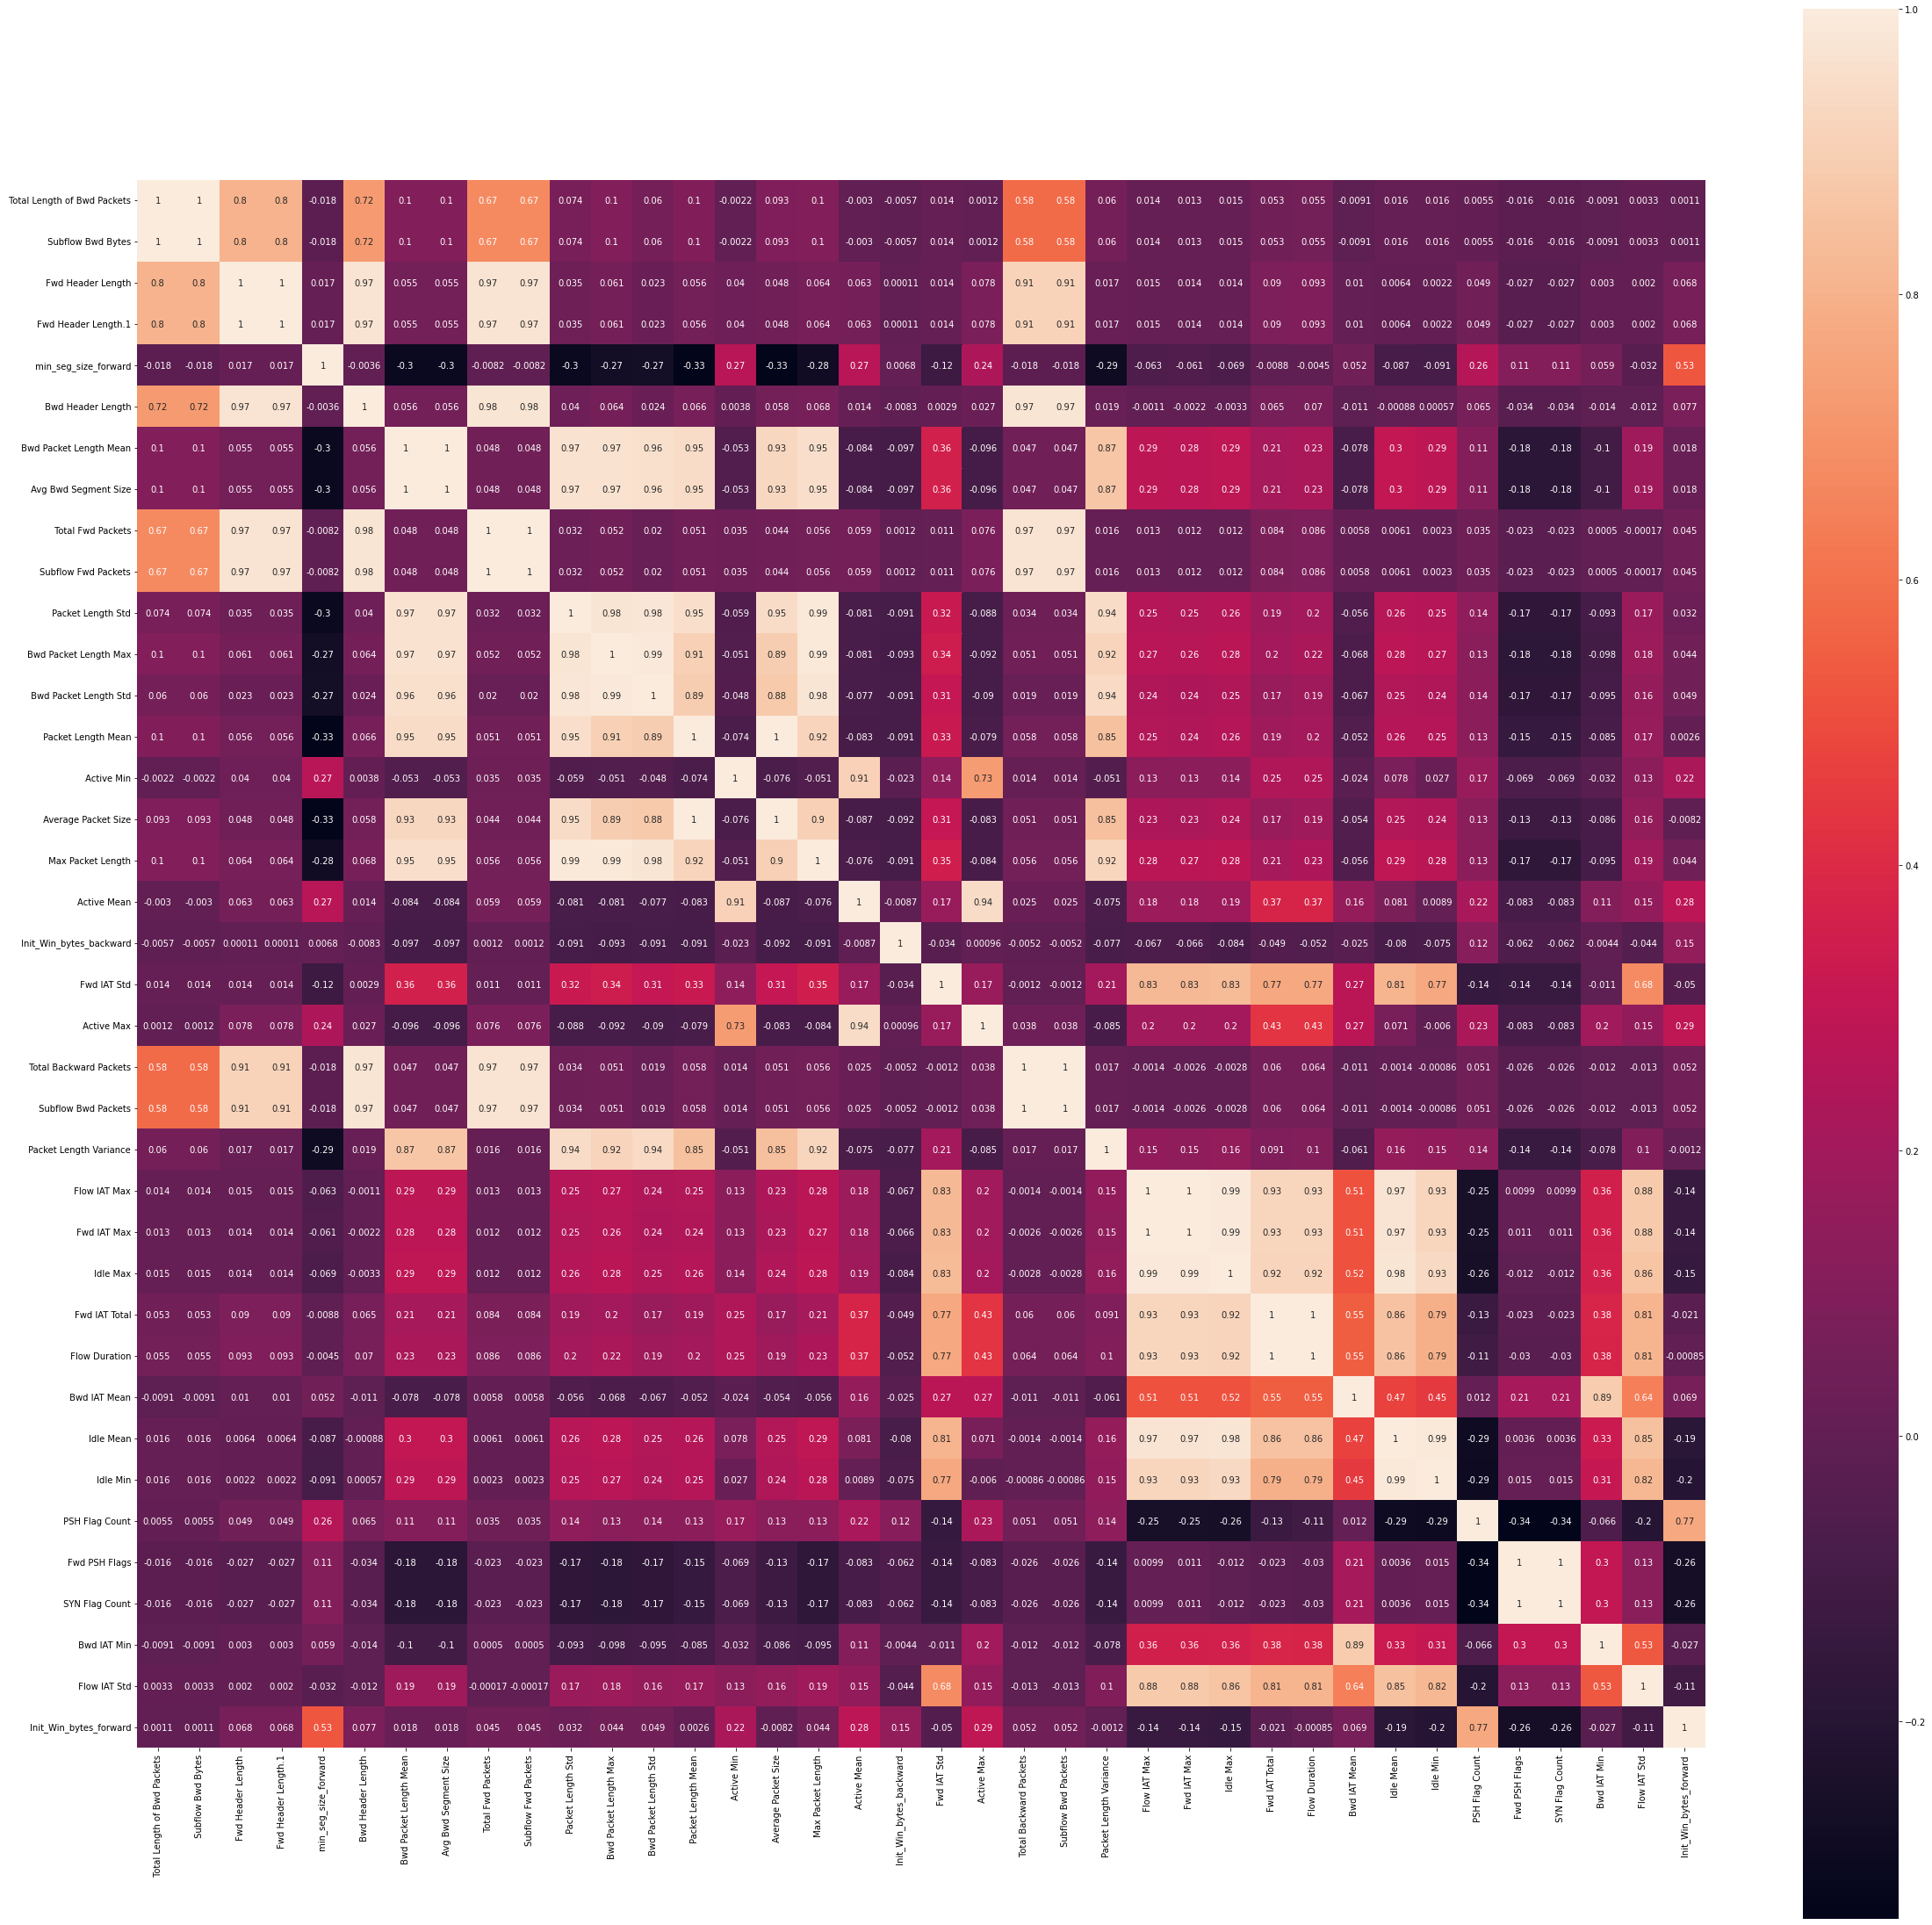

In [17]:
fig= plt.figure(figsize=(40,40))
sns.heatmap(feature.corr(), annot=True, square=True)

Корреляция, статистический метод, который определяет, как одна переменная перемещается / изменяется по отношению к другой переменной. Когда у нас есть сильно коррелированные функции в наборе данных, это увеличивает дисперсию и ненадежность. Коррелеяция замечена с признаками:

* Total Length of Bwd Packets
* Subflow Bwd Bytes
* Fwd Header Length
* Fwd Header Length.1
* Bwd Header Length
* Total Fwd Packets
* Subflow Fwd Packets
* Bwd Packets Length Mean
* Avg Bwd Segment Size
* Packet Length Std
* Bwd Packet Length Max
* Bwd Packet Length Std
* Packet Length Mean
* Flow IAT Max
* Fwd IAT Max
* Fwd IAT Total
* Idle Max
* Flow Duration
* Idle Mean
* Idle Min

Отбросим данные поля для повышения качества датасета
                

In [18]:
feature.drop([' Total Length of Bwd Packets'],axis=1,inplace=True)


In [19]:
feature.drop([' Subflow Bwd Bytes'],axis=1,inplace=True)

In [20]:
feature.drop([' Total Fwd Packets'],axis=1,inplace=True)


In [21]:
feature.drop(['Subflow Fwd Packets'],axis=1,inplace=True)

In [23]:
feature.drop([' Bwd Packet Length Mean'],axis=1,inplace=True)

In [24]:
feature.drop([' Avg Bwd Segment Size'],axis=1,inplace=True)

In [25]:
feature.drop([' Packet Length Std'],axis=1,inplace=True)

In [26]:
feature.drop(['Bwd Packet Length Max'],axis=1,inplace=True)

In [27]:
feature.drop([' Bwd Packet Length Std'],axis=1,inplace=True)

In [28]:
feature.drop([' Packet Length Mean'],axis=1,inplace=True)

In [22]:
feature.drop([' Average Packet Size'],axis=1,inplace=True)

In [29]:
feature.drop([' Max Packet Length'],axis=1,inplace=True)

In [30]:
feature.drop([' Flow IAT Max'],axis=1,inplace=True)

In [31]:
feature.drop([' Fwd IAT Max'],axis=1,inplace=True)

In [32]:
feature.drop(['Fwd IAT Total'],axis=1,inplace=True)

In [33]:
feature.drop([' Idle Max'],axis=1,inplace=True)

In [34]:
feature.drop([' Flow Duration'],axis=1,inplace=True)

In [35]:
feature.drop(['Idle Mean'],axis=1,inplace=True)

In [36]:
feature.drop([' Idle Min'],axis=1,inplace=True)

Проверим тепловую карту опять на предмет коррелирующих признаков

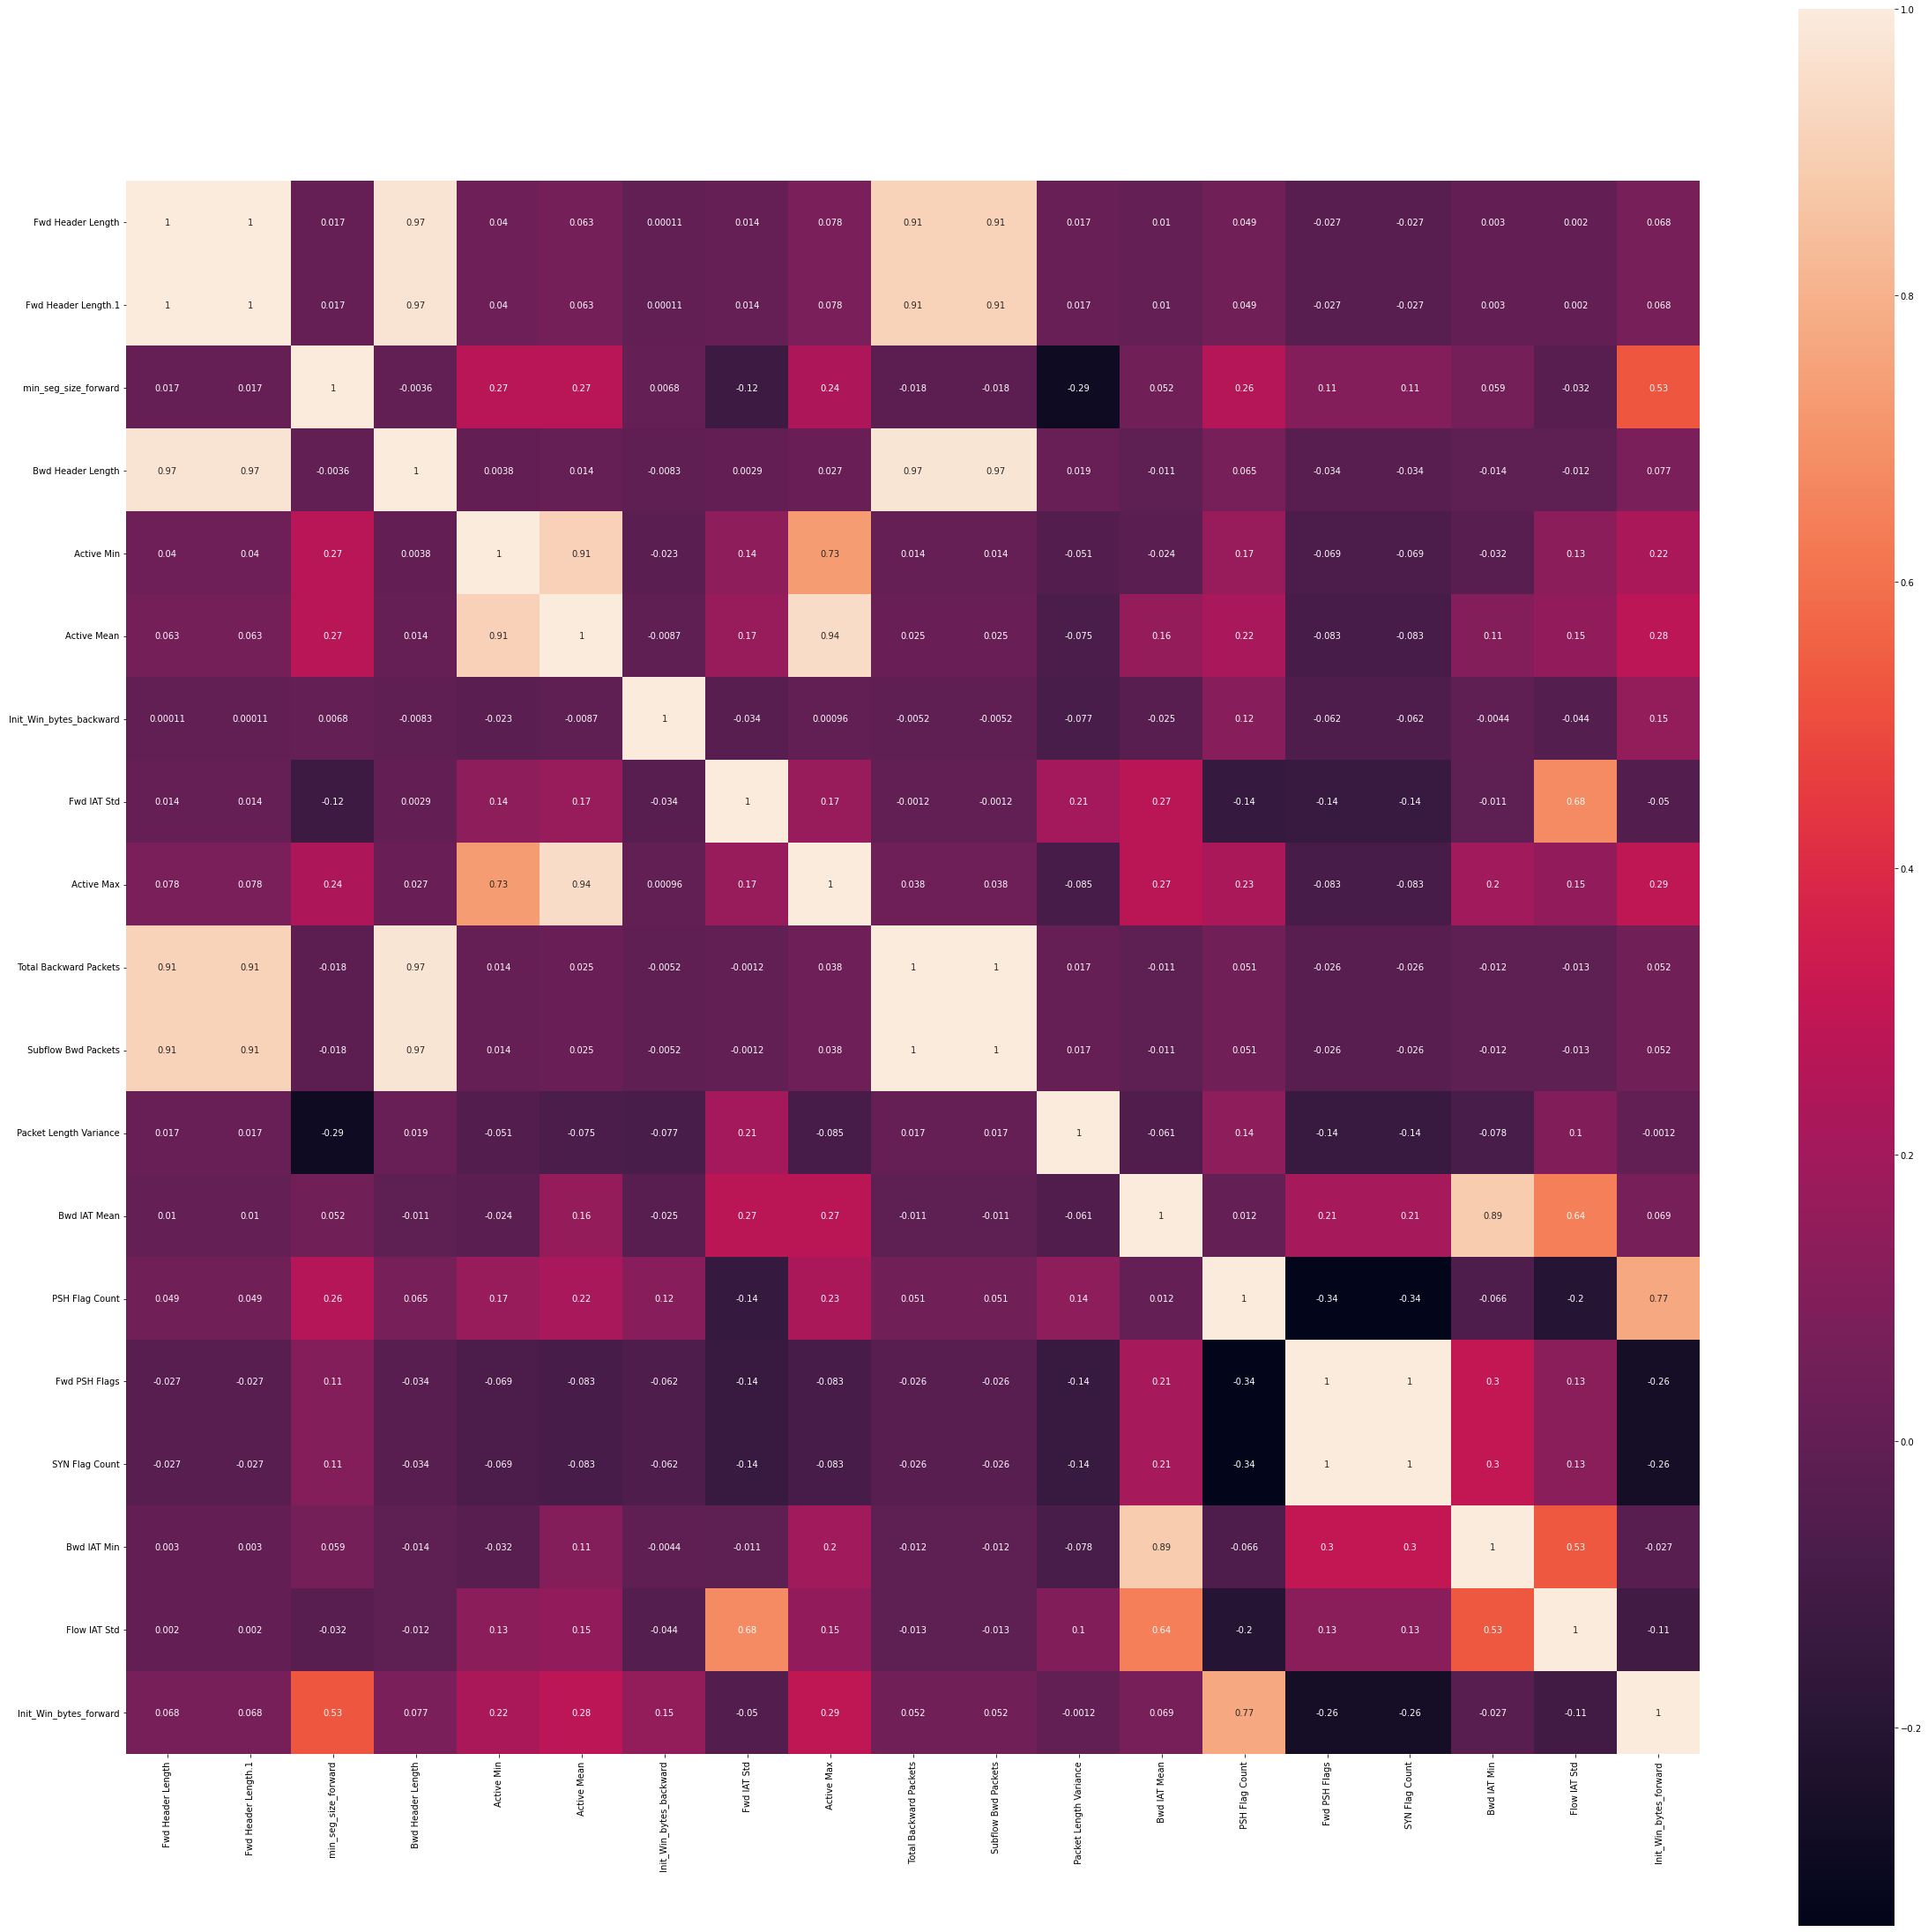

In [37]:
fig= plt.figure(figsize=(40,40))
sns.heatmap(feature.corr(), annot=True, square=True)

Подсчитаем оставшееся количество пакетов после удаления признаков

In [38]:
feature[' Label'].value_counts()

BENIGN                        13639
DoS GoldenEye                 10293
DDoS                          10242
PortScan                       9536
DoS Hulk                       9243
FTP-Patator                    7938
SSH-Patator                    5897
DoS slowloris                  5796
DoS Slowhttptest               5499
Bot                            1966
Web Attack � Brute Force       1507
Web Attack � XSS                652
Infiltration                     36
Web Attack � Sql Injection       21
Heartbleed                       11
Name:  Label, dtype: int64

In [ ]:
#attackType = feature[' Label'].unique()
#feature[' Label'] = feature[' Label'].astype('category')
#feature[' Label'] = feature[' Label'].astype("category").cat.codes

In [ ]:
#print (attackType)
#print (feature[' Label'].value_counts())

NameError: ignored

In [39]:
feature.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82276 entries, 24072 to 9242
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0    Fwd Header Length        82276 non-null  int32  
 1    Fwd Header Length.1      82276 non-null  int32  
 2    min_seg_size_forward     82276 non-null  int16  
 3    Bwd Header Length        82276 non-null  int32  
 4    Active Min               82276 non-null  int32  
 5   Active Mean               82276 non-null  float32
 6    Init_Win_bytes_backward  82276 non-null  int32  
 7    Fwd IAT Std              82276 non-null  float32
 8    Active Max               82276 non-null  int32  
 9    Total Backward Packets   82276 non-null  int32  
 10   Subflow Bwd Packets      82276 non-null  int32  
 11   Packet Length Variance   82276 non-null  float32
 12   Bwd IAT Mean             82276 non-null  float32
 13   PSH Flag Count           82276 non-null  int8   
 14  Fwd

In [40]:
feature0 = feature[feature[' Label'] == 0]
feature0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0    Fwd Header Length        0 non-null      int32  
 1    Fwd Header Length.1      0 non-null      int32  
 2    min_seg_size_forward     0 non-null      int16  
 3    Bwd Header Length        0 non-null      int32  
 4    Active Min               0 non-null      int32  
 5   Active Mean               0 non-null      float32
 6    Init_Win_bytes_backward  0 non-null      int32  
 7    Fwd IAT Std              0 non-null      float32
 8    Active Max               0 non-null      int32  
 9    Total Backward Packets   0 non-null      int32  
 10   Subflow Bwd Packets      0 non-null      int32  
 11   Packet Length Variance   0 non-null      float32
 12   Bwd IAT Mean             0 non-null      float32
 13   PSH Flag Count           0 non-null      int8   
 14  Fwd PSH Flags         

In [41]:
y = feature[' Label']
X = feature.drop([' Label'],axis=1)

<h2>Сэмплируем недостающее количество записей для балансировки датасета.</h2>

In [42]:
from imblearn.under_sampling import RandomUnderSampler

RandSamp = RandomUnderSampler('majority')
X_RandS, y_RandS = RandSamp.fit_resample(X, y)

/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:591: FutureWarning: Pass sampling_strategy=majority as keyword args. From version 0.9 passing these as positional arguments will result in an error
  FutureWarning,


In [43]:
X_RandS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68648 entries, 0 to 68647
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0    Fwd Header Length        68648 non-null  int32  
 1    Fwd Header Length.1      68648 non-null  int32  
 2    min_seg_size_forward     68648 non-null  int16  
 3    Bwd Header Length        68648 non-null  int32  
 4    Active Min               68648 non-null  int32  
 5   Active Mean               68648 non-null  float32
 6    Init_Win_bytes_backward  68648 non-null  int32  
 7    Fwd IAT Std              68648 non-null  float32
 8    Active Max               68648 non-null  int32  
 9    Total Backward Packets   68648 non-null  int32  
 10   Subflow Bwd Packets      68648 non-null  int32  
 11   Packet Length Variance   68648 non-null  float32
 12   Bwd IAT Mean             68648 non-null  float32
 13   PSH Flag Count           68648 non-null  int8   
 14  Fwd PS

In [44]:
y_RandS.value_counts()

DoS GoldenEye                 10293
DDoS                          10242
PortScan                       9536
DoS Hulk                       9243
FTP-Patator                    7938
SSH-Patator                    5897
DoS slowloris                  5796
DoS Slowhttptest               5499
Bot                            1966
Web Attack � Brute Force       1507
Web Attack � XSS                652
Infiltration                     36
Web Attack � Sql Injection       21
BENIGN                           11
Heartbleed                       11
Name:  Label, dtype: int64

In [45]:
from imblearn.combine import SMOTETomek

smt = SMOTETomek('not majority' ,n_jobs=-1)
X_smt, y_smt = smt.fit_resample(X_RandS, y_RandS)

/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:591: FutureWarning: Pass sampling_strategy=not majority as keyword args. From version 0.9 passing these as positional arguments will result in an error
  FutureWarning,


In [46]:
y_smt.value_counts()

FTP-Patator                   10293
BENIGN                        10293
Heartbleed                    10293
SSH-Patator                   10292
Infiltration                  10292
PortScan                      10289
Web Attack � Sql Injection    10288
DoS GoldenEye                 10286
Bot                           10284
DoS slowloris                 10275
DoS Slowhttptest              10268
DoS Hulk                      10250
DDoS                          10242
Web Attack � Brute Force       8999
Web Attack � XSS               8993
Name:  Label, dtype: int64

In [48]:
y_smt.head(200)

0      BENIGN
1      BENIGN
2      BENIGN
3      BENIGN
4      BENIGN
5      BENIGN
6      BENIGN
7      BENIGN
8      BENIGN
9      BENIGN
10     BENIGN
11        Bot
12        Bot
13        Bot
14        Bot
15        Bot
16        Bot
17        Bot
18        Bot
19        Bot
20        Bot
21        Bot
22        Bot
23        Bot
24        Bot
25        Bot
26        Bot
27        Bot
28        Bot
29        Bot
30        Bot
31        Bot
32        Bot
33        Bot
34        Bot
35        Bot
36        Bot
37        Bot
38        Bot
39        Bot
40        Bot
41        Bot
42        Bot
43        Bot
44        Bot
45        Bot
46        Bot
47        Bot
48        Bot
49        Bot
50        Bot
51        Bot
52        Bot
53        Bot
54        Bot
55        Bot
56        Bot
57        Bot
58        Bot
59        Bot
60        Bot
61        Bot
62        Bot
63        Bot
64        Bot
65        Bot
66        Bot
67        Bot
68        Bot
69        Bot
70        Bot
71    

In [ ]:
X_smt.head(5)

,min_seg_size_forward,Active Min,Active Mean,Init_Win_bytes_backward,Fwd IAT Std,Active Max,Packet Length Variance,Bwd IAT Mean,PSH Flag Count,Fwd PSH Flags,SYN Flag Count,Bwd IAT Min,Flow IAT Std,Init_Win_bytes_forward,URG Flag Count,Bwd Packet Length Min,Down/Up Ratio,Bwd IAT Max,Active Std,Bwd IAT Total,FIN Flag Count,Destination Port,Flow IAT Mean
0,32,0,0.0,0,1.668856e+04,0,807409.375000,614.5,0,0,0,218,1.325170e+04,110,0,6,0,1011,0.0,1229,0,34240,4960.3750
1,32,0,0.0,-1,0.000000e+00,0,736.333313,0.0,0,0,0,0,0.000000e+00,-1,0,91,1,0,0.0,0,0,53,50985.0000
2,20,0,0.0,-1,0.000000e+00,0,0.000000,0.0,0,0,0,0,0.000000e+00,255,0,0,0,0,0.0,0,0,443,9330.0000
3,20,0,0.0,351,1.618691e+06,0,355.952393,0.0,0,1,1,0,1.450801e+06,256,0,46,0,0,0.0,0,0,443,670819.8125
4,32,0,0.0,43440,0.000000e+00,0,0.000000,0.0,0,0,0,0,0.000000e+00,5782,0,0,1,0,0.0,0,0,40652,41.0000


In [49]:
#X_smt.insert(23, 'label', y_smt[0], True)
#X_smt.drop([X_smt.columns[0], axis = 1, inplace=True)
X_smt = X_smt.assign(label = y_smt)

In [51]:
X_smt.head(100)

,Fwd Header Length,Fwd Header Length.1,min_seg_size_forward,Bwd Header Length,Active Min,Active Mean,Init_Win_bytes_backward,Fwd IAT Std,Active Max,Total Backward Packets,Subflow Bwd Packets,Packet Length Variance,Bwd IAT Mean,PSH Flag Count,Fwd PSH Flags,SYN Flag Count,Bwd IAT Min,Flow IAT Std,Init_Win_bytes_forward,label
0,20,20,20,20,0,0.000000,253,0.000000e+00,0,1,1,0.000000e+00,0.000000e+00,0,0,0,0,0.000000e+00,1013,BENIGN
1,132,132,20,192,24735,24735.000000,256,3.300000e+07,24735,9,9,4.816099e+06,9.225707e+06,0,0,0,1,1.750000e+07,229,BENIGN
2,40,40,20,40,0,0.000000,-1,0.000000e+00,0,2,2,3.121200e+03,3.000000e+00,0,0,0,3,2.718021e+04,-1,BENIGN
3,80,80,20,40,0,0.000000,-1,1.873214e+04,0,2,2,1.194667e+04,3.000000e+00,0,0,0,3,1.658597e+04,-1,BENIGN
4,32,32,32,32,0,0.000000,-1,0.000000e+00,0,1,1,8.533334e+01,0.000000e+00,0,0,0,0,0.000000e+00,-1,BENIGN
5,64,64,32,0,0,0.000000,-1,0.000000e+00,0,0,0,3.203333e+02,0.000000e+00,0,1,1,0,0.000000e+00,558,BENIGN
6,40,40,20,40,0,0.000000,-1,0.000000e+00,0,2,2,1.009200e+03,4.000000e+00,0,0,0,4,9.555278e+01,-1,BENIGN
7,40,40,20,40,0,0.000000,-1,0.000000e+00,0,2,2,6.912000e+02,4.000000e+00,0,0,0,4,1.877254e+04,-1,BENIGN
8,11752,11752,20,18732,93535,557271.000000,509,3.433445e+06,1021007,936,936,9.506726e+05,1.269352e+05,1,0,0,1,2.130238e+06,8192,BENIGN
9,64,64,32,64,0,0.000000,-1,0.000000e+00,0,2,2,4.800000e+02,2.000000e+00,0,0,0,2,1.215698e+04,-1,BENIGN


<h2> Сохраним и разделим датасет на тестовую и тренировочную часть </h2>

In [52]:
X_smt.to_csv('/content/drive/MyDrive/CICIDS2017/devtest/X_smt_test.csv', index = False)

In [ ]:
#X_smt.to_csv('/content/drive/MyDrive/CICIDS2017/devtest/X_smt.csv')
#y_smt.to_csv('/content/drive/MyDrive/CICIDS2017/devtest/y_smt.csv')

In [ ]:
#y_smt.value_counts()

Разделение датасета на тестовый и тренировочный

In [ ]:
#X_smt=pd.read_csv('/content/drive/MyDrive/CICIDS2017/devtest/X_smt.csv')
#y_smt=pd.read_csv('/content/drive/MyDrive/CICIDS2017/devtest/y_smt.csv')


#train_X,test_X,train_y,test_y=train_test_split(X_smt,y_smt,test_size=0.3, random_state=10)

#from numpy.random import RandomState
#rng = RandomState()

#train_X = X_smt.sample(frac=0.7, random_state=rng)
#test_X = X_smt.loc[~X_smt.index.isin(train_X.index)]

#train_y = y_smt.sample(frac=0.7, random_state=rng)
#test_y = y_smt.loc[~X_smt.index.isin(train_y.index)]

In [ ]:
#print(train_X.shape, train_y.shape)

(106122, 20) (106122, 2)


In [ ]:
#print(train_y)

In [ ]:
#train_y.drop(['Unnamed: 0'], axis='columns', inplace=True)
#train_X.drop(['Unnamed: 0'], axis='columns', inplace=True)
#train_y.drop(train_y.columns[0], axis='columns', inplace=True)

In [1]:
#train_X.insert(0, ['Label'], train_y, True)

In [5]:
file = pd.read_csv('/content/drive/MyDrive/CICIDS2017/devtest/X_smt_test.csv')
file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151637 entries, 0 to 151636
Data columns (total 20 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0    Fwd Header Length        151637 non-null  int64  
 1    Fwd Header Length.1      151637 non-null  int64  
 2    min_seg_size_forward     151637 non-null  int64  
 3    Bwd Header Length        151637 non-null  int64  
 4    Active Min               151637 non-null  int64  
 5   Active Mean               151637 non-null  float64
 6    Init_Win_bytes_backward  151637 non-null  int64  
 7    Fwd IAT Std              151637 non-null  float64
 8    Active Max               151637 non-null  int64  
 9    Total Backward Packets   151637 non-null  int64  
 10   Subflow Bwd Packets      151637 non-null  int64  
 11   Packet Length Variance   151637 non-null  float64
 12   Bwd IAT Mean             151637 non-null  float64
 13   PSH Flag Count           151637 non-null  i

In [6]:
!head -n 4000 '/content/drive/MyDrive/CICIDS2017/devtest/X_smt_test.csv'

 Fwd Header Length, Fwd Header Length.1, min_seg_size_forward, Bwd Header Length, Active Min,Active Mean, Init_Win_bytes_backward, Fwd IAT Std, Active Max, Total Backward Packets, Subflow Bwd Packets, Packet Length Variance, Bwd IAT Mean, PSH Flag Count,Fwd PSH Flags, SYN Flag Count, Bwd IAT Min, Flow IAT Std,Init_Win_bytes_forward,label
20,20,20,20,0,0.0,253,0.0,0,1,1,0.0,0.0,0,0,0,0,0.0,1013,BENIGN
132,132,20,192,24735,24735.0,256,33000000.0,24735,9,9,4816099.0,9225707.0,0,0,0,1,17500000.0,229,BENIGN
40,40,20,40,0,0.0,-1,0.0,0,2,2,3121.2,3.0,0,0,0,3,27180.207,-1,BENIGN
80,80,20,40,0,0.0,-1,18732.145,0,2,2,11946.667,3.0,0,0,0,3,16585.975,-1,BENIGN
32,32,32,32,0,0.0,-1,0.0,0,1,1,85.333336,0.0,0,0,0,0,0.0,-1,BENIGN
64,64,32,0,0,0.0,-1,0.0,0,0,0,320.33334,0.0,0,1,1,0,0.0,558,BENIGN
40,40,20,40,0,0.0,-1,0.0,0,2,2,1009.2,4.0,0,0,0,4,95.55278,-1,BENIGN
40,40,20,40,0,0.0,-1,0.0,0,2,2,691.2,4.0,0,0,0,4,18772.545,-1,BENIGN
11752,11752,20,18732,93535,557271.0,509,3433445.2,1021007,936,936,95067

In [7]:
data = []
target = []
file = pd.read_csv('/content/drive/MyDrive/CICIDS2017/devtest/X_smt_test.csv')
for n, i in file.iterrows():
  a = []
  for j in i[:-1]:
    a.append(j)
  data.append(a)

  target.append(0 if i[-1] == 'BENIGN' else 1) #0 benign 1 attack
del file

In [56]:
data[:5]

[[20, 20, 20, 20, 0, 0.0, 253, 0.0, 0, 1, 1, 0.0, 0.0, 0, 0, 0, 0, 0.0, 1013],
 [132,
  132,
  20,
  192,
  24735,
  24735.0,
  256,
  33000000.0,
  24735,
  9,
  9,
  4816099.0,
  9225707.0,
  0,
  0,
  0,
  1,
  17500000.0,
  229],
 [40,
  40,
  20,
  40,
  0,
  0.0,
  -1,
  0.0,
  0,
  2,
  2,
  3121.2,
  3.0,
  0,
  0,
  0,
  3,
  27180.207000000002,
  -1],
 [80,
  80,
  20,
  40,
  0,
  0.0,
  -1,
  18732.145,
  0,
  2,
  2,
  11946.667,
  3.0,
  0,
  0,
  0,
  3,
  16585.975,
  -1],
 [32,
  32,
  32,
  32,
  0,
  0.0,
  -1,
  0.0,
  0,
  1,
  1,
  85.333336,
  0.0,
  0,
  0,
  0,
  0,
  0.0,
  -1]]

In [8]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(np.nan_to_num(data).astype(float))
data = scaler.transform(np.nan_to_num(data).astype(float))
data = data.reshape(data.shape[0], 19)
#data = data.reshape(data.shape[0], 23, 1)

Задача: соединить датасеты и отделить бенигн (класс 0) и все остальные как атаки

In [9]:
data = np.array(data)
target = np.array(target)
print(data.shape, target.shape)

(151637, 19) (151637,)


Моделирование нейросети

In [10]:
lstm = Sequential()
lstm.add(Input((19, 1)))
lstm.add(LSTM(32, recurrent_activation='sigmoid', return_sequences=True, recurrent_dropout=0))
for i in range(3):
  lstm.add(LSTM(32, recurrent_activation='sigmoid', return_sequences=True, recurrent_dropout=0))
lstm.add(Flatten())
lstm.add(Dense(2 ,activation = 'softmax'))
lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')
lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 19, 32)            4352      
                                                                 
 lstm_1 (LSTM)               (None, 19, 32)            8320      
                                                                 
 lstm_2 (LSTM)               (None, 19, 32)            8320      
                                                                 
 lstm_3 (LSTM)               (None, 19, 32)            8320      
                                                                 
 flatten (Flatten)           (None, 608)               0         
                                                                 
 dense (Dense)               (None, 2)                 1218      
                                                                 
Total params: 30,530
Trainable params: 30,530
Non-traina

Тренировка нейросети

In [11]:
lstm.fit(data, to_categorical(target), epochs=20, batch_size=256, verbose=1)

lstm.save('/content/drive/MyDrive/CICIDS2017/devtest/devtestlstm.h5')

Epoch 1/20
593/593 [==============================] - 51s 75ms/step - loss: 0.1966 - accuracy: 0.9306
Epoch 2/20
593/593 [==============================] - 44s 75ms/step - loss: 0.1367 - accuracy: 0.9418
Epoch 3/20
593/593 [==============================] - 45s 76ms/step - loss: 0.1225 - accuracy: 0.9498
Epoch 4/20
593/593 [==============================] - 45s 76ms/step - loss: 0.1196 - accuracy: 0.9521
Epoch 5/20
593/593 [==============================] - 45s 76ms/step - loss: 0.1135 - accuracy: 0.9567
Epoch 6/20
593/593 [==============================] - 45s 76ms/step - loss: 0.1177 - accuracy: 0.9541
Epoch 7/20
593/593 [==============================] - 45s 76ms/step - loss: 0.1093 - accuracy: 0.9579
Epoch 8/20
593/593 [==============================] - 45s 76ms/step - loss: 0.1118 - accuracy: 0.9563
Epoch 9/20
593/593 [==============================] - 45s 76ms/step - loss: 0.1067 - accuracy: 0.9597
Epoch 10/20
593/593 [==============================] - 45s 76ms/step - loss: 0.101

Получение данных от нейросети

In [12]:
y_pred1 = lstm.predict(data, batch_size=1024)
y_pred = np.argmax(y_pred1, axis=1)

Вычисление метрик и количества пакетов с атакой и без

In [36]:
from sklearn import metrics
from sklearn.metrics import classification_report
target_names = ['Benign', 'Attack']
print('==============================Classification Report=============================='.format(i))
print(classification_report(target, y_pred, target_names=target_names))
print('==============================Confussion Matrix and metrics=============================='.format(i))
tn, fp, fn, tp = confusion_matrix(target, y_pred).ravel()
sum = tn + fp + fn + tp
print('Confussion Matrix:', "\n", confusion_matrix(target, y_pred))
print("Accuracy: ", accuracy_score(target, y_pred))
recall = tp / (tp + fn)
print('recall:', recall)
precision = tp / (tp + fp)
print('precision:', precision)
print('f1 score:', 2 * (precision * recall) / (precision + recall))
print('ROC AUC:', roc_auc_score(target, y_pred))

metrics.plot_roc_curve(lstm, target, y_pred) 

unique, counts = np.unique(y_pred, return_counts=True)
count_list = dict(zip(unique, counts))
print('Alghorythm marked', count_list[1], 'as attack and', count_list[0], "packets as benign")

==============================Classification Report==============================
              precision    recall  f1-score   support

      Benign       0.87      0.85      0.86     10293
      Attack       0.99      0.99      0.99    141344

    accuracy                           0.98    151637
   macro avg       0.93      0.92      0.92    151637
weighted avg       0.98      0.98      0.98    151637

==============================Confussion Matrix and metrics==============================
Confussion Matrix: 
 [[  8747   1546]
 [  1365 139979]]
Accuracy:  0.980802838357393
recall: 0.9903427099841522
precision: 0.9890761349584879
f1 score: 0.9897090172482669
ROC AUC: 0.9200717727517186


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


ValueError: ignored

Чтение датасета для второй нейросети. KNN

In [ ]:
data = []
target = []
last = []

file = pd.read_csv('/content/drive/MyDrive/CICIDS2017/devtest/X_smt_test.csv')
  for n, i in file.iterrows():
      if not i[-1] in last:
          last.append(i[-1])
      if last.index(i[-1]) != 0:
        a = []
        for j in i[:-1]:
            a.append(j)
        data.append(a)
        target.append(last.index(i[-1])-1)
del file
del last[0]

Обработка

In [ ]:
data = np.array(data)
target = np.array(target)
data = data.reshape(data.shape[0], 78)
print(data.shape, target.shape)

Загрузка нормализатора

In [ ]:
scaler = pickle.load(open('/content/drive/MyDrive/scaler.pkl', 'rb'))

Нормализация данных для второй нейросети

In [ ]:
data = scaler.transform(np.nan_to_num(data).astype(float))

Моделирование второй нейросети

In [ ]:
knn = Sequential()
knn.add(InputLayer((78,)))
knn.add(BatchNormalization())
knn.add(Dense(128, activation='relu'))
knn.add(Dense(128, activation='relu'))
knn.add(Dense(14, activation='softmax'))
#optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
knn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

Тренировка второй нейросети

In [ ]:
knn.fit(data.astype(float), target, epochs=10, batch_size=256, verbose=1)

knn.save('/content/drive/MyDrive/knn.h5')

Получение данных со второй нейросети

In [ ]:
y_pred1 = knn.predict(data)
y_pred = np.argmax(y_pred1, axis=1)

Вычисление метрик и количество классов

In [ ]:
print('recall:', recall_score(target, y_pred, average='micro'))
print('precision:', precision_score(target, y_pred, average='micro'))
print('accuracy:', accuracy_score(target, y_pred))
print('f1 score:', f1_score(target, y_pred, average='micro'))
print('ROC AUC:', roc_auc_score(to_categorical(target), np.nan_to_num(y_pred1), multi_class='ovr'))
print('матрица неточностей', confusion_matrix(target, y_pred))
unique, counts = np.unique(y_pred, return_counts=True)
count_list = dict(zip(unique, counts))
print('Классы:')
for i in count_list:
  print(last[i], count_list[i])

-

-

-

Здесь начинается проверка нейросети

In [ ]:
from tensorflow.keras.models import load_model
import numpy as np
import pandas as pd

Загрузка заранее обученной нейросети

In [ ]:
lstm = load_model('/content/drive/MyDrive/lstm.h5')
knn = load_model('/content/drive/MyDrive/knn.h5')

Загрузка данных для тестирования нейросети

In [ ]:
file = pd.read_csv('/content/drive/MyDrive/net/Tuesday-WorkingHours.pcap_ISCX.csv')
data = []
target = []

for n, i in file.iterrows():
        a = []
        for j in i[:-1]:
          a.append(j)
        data.append(a)
        target.append(last.index(i[-1]))

Обработка данных

In [ ]:
data = np.array(data)
target = np.array(target)
data = data.reshape(data.shape[0], 78, 1)
print(data.shape, target.shape)

Проверка нейросети

In [ ]:
model.evaluate(data, target)

Предсказание нейросети

In [ ]:
pred = model.predict(data)

Определение класса предсказанния нейросети

In [ ]:
print(last[np.argmax(pred[5])])